In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import sys
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from project_resources.import_utils import NotebookFinder
sys.meta_path.append(NotebookFinder())
from project_resources.cytochrome_P450 import fp_from_smiles, parse_jazzy_df, HyperparamTuner, tanimoto

importing Jupyter notebook from C:\Users\Lukas\Documents\datacytochromy\project_resources\cytochrome_P450.ipynb


In [59]:
model_identifiers = ["linear", "KRR", "GB", "RF", "ANN"]
isozymes = ["3A4", "RLM", "HLC"]
splitters = ["rand", "scaff", "time"]
data_splits = ["train", "test"]
feature_types = ["morgan", "jazzy"]
rel_paths = rel_paths = {
    "morgan_3A4_train_scaff": r"project_resources/base_splits/scaffold_splitter/3A4_train.csv",
    "morgan_3A4_train_rand": r"project_resources/base_splits/random/3A4_train.csv",
    "morgan_3A4_train_time": r"project_resources/base_splits/time_split/3A4_train.csv",
    "morgan_RLM_train_scaff": r"project_resources/base_splits/scaffold_splitter/RLM_train.csv",
    "morgan_RLM_train_rand": r"project_resources/base_splits/random/RLM_train.csv",
    "morgan_RLM_train_time": r"project_resources/base_splits/time_split/RLM_train.csv",
    "morgan_HLC_train_scaff": r"project_resources/base_splits/scaffold_splitter/HLC_train.csv",
    "morgan_HLC_train_rand": r"project_resources/base_splits/random/HLC_train.csv",
    "morgan_HLC_train_time": r"project_resources/base_splits/time_split/HLC_train.csv",

    "morgan_3A4_test_scaff": r"project_resources/base_splits/scaffold_splitter/3A4_test.csv",
    "morgan_3A4_test_rand": r"project_resources/base_splits/random/3A4_test.csv",
    "morgan_3A4_test_time": r"project_resources/base_splits/time_split/3A4_test.csv",
    "morgan_RLM_test_scaff": r"project_resources/base_splits/scaffold_splitter/RLM_test.csv",
    "morgan_RLM_test_rand": r"project_resources/base_splits/random/RLM_test.csv",
    "morgan_RLM_test_time": r"project_resources/base_splits/time_split/RLM_test.csv",
    "morgan_HLC_test_scaff": r"project_resources/base_splits/scaffold_splitter/HLC_test.csv",
    "morgan_HLC_test_rand": r"project_resources/base_splits/random/HLC_test.csv",
    "morgan_HLC_test_time": r"project_resources/base_splits/time_split/HLC_test.csv",

    "jazzy_3A4_train_scaff": r"project_resources/jazzy_splits/scaffold_splitter/3A4_train.csv",
    "jazzy_3A4_train_rand": r"project_resources/jazzy_splits/random/3A4_train.csv",
    "jazzy_3A4_train_time": r"project_resources/jazzy_splits/time_split/3A4_train.csv",
    "jazzy_RLM_train_scaff": r"project_resources/jazzy_splits/scaffold_splitter/RLM_train.csv",
    "jazzy_RLM_train_rand": r"project_resources/jazzy_splits/random/RLM_train.csv",
    "jazzy_RLM_train_time": r"project_resources/jazzy_splits/time_split/RLM_train.csv",
    "jazzy_HLC_train_scaff": r"project_resources/jazzy_splits/scaffold_splitter/HLC_train.csv",
    "jazzy_HLC_train_rand": r"project_resources/jazzy_splits/random/HLC_train.csv",
    "jazzy_HLC_train_time": r"project_resources/jazzy_splits/time_split/HLC_train.csv",

    "jazzy_3A4_test_scaff": r"project_resources/jazzy_splits/scaffold_splitter/3A4_test.csv",
    "jazzy_3A4_test_rand": r"project_resources/jazzy_splits/random/3A4_test.csv",
    "jazzy_3A4_test_time": r"project_resources/jazzy_splits/time_split/3A4_test.csv",
    "jazzy_RLM_test_scaff": r"project_resources/jazzy_splits/scaffold_splitter/RLM_test.csv",
    "jazzy_RLM_test_rand": r"project_resources/jazzy_splits/random/RLM_test.csv",
    "jazzy_RLM_test_time": r"project_resources/jazzy_splits/time_split/RLM_test.csv",
    "jazzy_HLC_test_scaff": r"project_resources/jazzy_splits/scaffold_splitter/HLC_test.csv",
    "jazzy_HLC_test_rand": r"project_resources/jazzy_splits/random/HLC_test.csv",
    "jazzy_HLC_test_time": r"project_resources/jazzy_splits/time_split/HLC_test.csv"
}
smiles = {}
halflives = {}
models = {}
mol_features = {}
best_model_hyperparams = {}
tanimoto_sims = {}
fingerprints = {}
y_predicted = {}
rmsds = {}
stds = {}
best_models = {}

In [60]:
# load all models from optuna
# and get the hyperparameters of the best model from each study
# doesn't get the user_attrs={'fit_intercept': True} from linear, need to get manually
for _type in feature_types:
    models[_type] = {}
    best_model_hyperparams[_type] = {}
    for splitter in splitters:
        models[_type][splitter] = {}
        best_model_hyperparams[_type][splitter] = {}
        if splitter == "rand":
            splitter_name = "random"
        elif splitter == "scaff":
            splitter_name = "scaffold_splitter"
        else:
            splitter_name = "time_split"
        for isozyme in isozymes:
            models[_type][splitter][isozyme] = {}
            best_model_hyperparams[_type][splitter][isozyme] = {}
            for model_id in model_identifiers:
                jl = joblib.load(f"project_resources/optuna/{_type}/{splitter_name}/{isozyme}/{model_id}.pkl")
                models[_type][splitter][isozyme][model_id] = jl
                best_model_hyperparams[_type][splitter][isozyme][model_id] = jl.best_trial.params
print(models["morgan"]["rand"]["3A4"]["linear"].best_trial)
print(best_model_hyperparams["morgan"]["rand"]["3A4"]["linear"])

FrozenTrial(number=9, state=TrialState.COMPLETE, values=[1.364301123873657], datetime_start=datetime.datetime(2023, 10, 11, 6, 59, 3, 712704), datetime_complete=datetime.datetime(2023, 10, 11, 6, 59, 4, 616147), params={'alpha': 0.0632399399346352, 'l1_ratio': 0.687379545008854}, user_attrs={'fit_intercept': True}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=0.1, log=False, low=1e-05, step=None), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=10, value=None)
{'alpha': 0.0632399399346352, 'l1_ratio': 0.687379545008854}


In [61]:
for model_id in model_identifiers:
    print(best_model_hyperparams["morgan"]["rand"]["3A4"][model_id])

{'alpha': 0.0632399399346352, 'l1_ratio': 0.687379545008854}
{'alpha': 0.5132621967885778, 'gamma': 6.3123850372562914e-15, 'kernel': 'laplacian'}
{'n_estimators': 20, 'learning_rate': 0.3118949729393795, 'max_depth': 3}
{'n_estimators': 200, 'max_features': 'auto', 'max_depth': 5}
{'learning_rate_init': 0.04680948516148173, 'hidden_layer_sizes': [10, 10, 10]}


In [62]:
# load smiles used for ML with Morgan features
smiles["morgan"] = {}
halflives["morgan"] = {}
for splitter in splitters:
    print("\n")
    print(splitter)
    smiles["morgan"][splitter] = {}
    halflives["morgan"][splitter] = {}
    for isozyme in isozymes:
        smiles["morgan"][splitter][isozyme] = {}
        halflives["morgan"][splitter][isozyme] = {}
        for split in data_splits:
            print(isozyme, split)
            df = pd.read_csv(rel_paths[f"morgan_{isozyme}_{split}_{splitter}"])
            df_smiles = list(df["smiles"])
            df_halflives = list(df["half-life"])
            smiles["morgan"][splitter][isozyme][split] = df_smiles
            halflives["morgan"][splitter][isozyme][split] = df_halflives
            print(smiles["morgan"][splitter][isozyme][split][0], halflives["morgan"][splitter][isozyme][split][0])



rand
3A4 train
CC(C)(O)c1cc(F)c2c(c1)C(=O)N(Cc1ccc(Cl)cn1)[C@@]2(OCC1(O)CC1)c1ccc(Cl)cc1 6.0
3A4 test
Cc1ncsc1-c1ccc([C@H](CC(=O)NCCCCCCNC(=O)COc2c(-c3csc(N4CCOCC4)n3)ccc(F)c2F)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)C2(F)CC2)C(C)(C)C)cc1 0.3767
RLM train
O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12 30.0
RLM test
Cc1ccc(OCCn2c(CCNC(=O)N3CCCCC3)nc3ccccc32)cc1 1.7
HLC train
N#Cc1ccc(CN2CCC(N3CCNC3=O)CC2)cc1 93.2
HLC test
c1ccc(Nc2ncc(-c3cncnc3)c3c2OCC3)cc1 120.0


scaff
3A4 train
COc1cccc([C@@H](CO)NC(=O)[C@@H](C)N2Cc3ccc(-c4nc(NC5CCOCC5)ncc4Cl)cc3C2=O)c1 0.09167
3A4 test
O=C1CCC(N2C(=O)c3cccc(NCCOCCOCCNC(=O)c4ccc5c(c4)nc(Nc4cccc(Cl)c4)c4ccncc45)c3C2=O)C(=O)N1 0.2433
RLM train
CS(=O)(=O)c1ccccc1-c1csc(N2CCC(C(N)=O)CC2)n1 30.0
RLM test
COCCCNC(=O)c1cc2cc(S(=O)(=O)N(C)C)ccc2n1C 25.0
HLC train
Cc1cc(F)ccc1OC1CN(Cc2ccc(C#N)cc2)C1 35.4
HLC test
Fc1cccc(-c2cnc([C@@H]3COCCN3Cc3cnc[nH]3)[nH]2)c1 59.3


time
3A4 train
O=C(NC1CCN(CCc2c[nH]c3ccccc23)CC1)c1ccccc1 0.2667
3A4 test
COc1cc(F)cc([C@@H](CO)NC(=

In [63]:
# load Jazzy features from csv files and their corresponding smiles
smiles["jazzy"] = {}
halflives["jazzy"] = {}
for splitter in splitters:
    print("\n")
    print(splitter)
    mol_features[splitter] = {}
    smiles["jazzy"][splitter] = {}
    halflives["jazzy"][splitter] = {}
    for isozyme in isozymes:
        mol_features[splitter][isozyme] = {}
        smiles["jazzy"][splitter][isozyme] = {}
        halflives["jazzy"][splitter][isozyme] = {}
        for split in data_splits:
            print(isozyme, split)
            df = pd.read_csv(rel_paths[f"jazzy_{isozyme}_{split}_{splitter}"])
            jazzy_smiles, features, thalfs, contains_nan = parse_jazzy_df(df)
            smiles["jazzy"][splitter][isozyme][split] = jazzy_smiles
            mol_features[splitter][isozyme][split] = features
            halflives["jazzy"][splitter][isozyme][split] = thalfs
            print(smiles["jazzy"][splitter][isozyme][split].shape, mol_features[splitter][isozyme][split].shape, halflives["jazzy"][splitter][isozyme][split].shape)
            print(f"     {mol_features[splitter][isozyme][split][0]}")
            print(f"     {isozyme} mol_features {split} contains NaN: {contains_nan}")



rand
3A4 train
     56, [63, 'CC(C)(O)c1cc(F)c2c(c1)C(=O)N(Cc1ccc(Cl)cn1)[C@@]2(OCC1(O)CC1)c1ccc(Cl)cc1', 6.0, 13.1753, 1.4177, 11.3044, -7.3559, -125.8906, -119.4889]
(56,) (56, 6) (56,)
     [  13.1753    1.4177   11.3044   -7.3559 -125.8906 -119.4889]
     3A4 mol_features train contains NaN: False
3A4 test
     14, [23, 'Cc1ncsc1-c1ccc([C@H](CC(=O)NCCCCCCNC(=O)COc2c(-c3csc(N4CCOCC4)n3)ccc(F)c2F)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)C2(F)CC2)C(C)(C)C)cc1', 0.3767, 28.4327, 3.274, 23.4872, -4.0348, -286.1545, -257.0326]
(14,) (14, 6) (14,)
     [  28.4327    3.274    23.4872   -4.0348 -286.1545 -257.0326]
     3A4 mol_features test contains NaN: False
RLM train
     removed index 1047 corresponding to NaN
     removed index 1517 corresponding to NaN
     2022, [158, 'O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12', 30.0, 8.0486, 0.0, 5.2165, -13.5913, -63.7029, -67.7504]
(2022,) (2022, 6) (2022,)
     [  8.0486   0.       5.2165 -13.5913 -63.7029 -67.7504]
     RLM mol_features train conta

In [66]:
# smiles to Morgan fingerprint
for _type in feature_types:
    fingerprints[_type] = {}  # need to destinguish between Jazzy and Morngan since Jazzy ommits some mols
    for splitter in splitters:
        fingerprints[_type][splitter] = {}
        for isozyme in isozymes:
            fingerprints[_type][splitter][isozyme] = {}
            for data_split in data_splits:
                fps = fp_from_smiles(smiles[_type][splitter][isozyme][data_split])
                fingerprints[_type][splitter][isozyme][data_split] = np.array(fps)
                print(_type, splitter, isozyme, data_split)
                print(f"first ten bits of the frist element: {fps[0][:10]}, number of bit vectors: {len(fps)}")
            print("\n")

morgan rand 3A4 train
first ten bits of the frist element: [1 1 1 0 1 0 1 1 1 1], number of bit vectors: 56
morgan rand 3A4 test
first ten bits of the frist element: [1 1 1 1 1 1 0 1 1 0], number of bit vectors: 14


morgan rand RLM train
first ten bits of the frist element: [0 0 0 0 0 0 0 0 1 1], number of bit vectors: 2024
morgan rand RLM test
first ten bits of the frist element: [1 0 0 1 0 1 0 1 0 0], number of bit vectors: 507


morgan rand HLC train
first ten bits of the frist element: [0 0 0 1 1 0 1 0 0 1], number of bit vectors: 151
morgan rand HLC test
first ten bits of the frist element: [0 1 0 0 0 0 0 0 0 0], number of bit vectors: 38


morgan scaff 3A4 train
first ten bits of the frist element: [0 1 0 1 0 1 1 1 0 1], number of bit vectors: 56
morgan scaff 3A4 test
first ten bits of the frist element: [0 1 1 1 0 1 0 0 0 1], number of bit vectors: 14


morgan scaff RLM train
first ten bits of the frist element: [1 0 0 1 1 1 0 0 0 0], number of bit vectors: 2024
morgan scaff RL

In [67]:
for splitter in splitters:
    for isozyme in isozymes:
        for split in data_splits:
            print(splitter, isozyme, split)
            print(np.array(mol_features[splitter][isozyme][split]).shape)

rand 3A4 train
(56, 6)
rand 3A4 test
(14, 6)
rand RLM train
(2022, 6)
rand RLM test
(505, 6)
rand HLC train
(151, 6)
rand HLC test
(38, 6)
scaff 3A4 train
(56, 6)
scaff 3A4 test
(14, 6)
scaff RLM train
(2020, 6)
scaff RLM test
(507, 6)
scaff HLC train
(151, 6)
scaff HLC test
(38, 6)
time 3A4 train
(56, 6)
time 3A4 test
(14, 6)
time RLM train
(2023, 6)
time RLM test
(504, 6)
time HLC train
(151, 6)
time HLC test
(38, 6)


In [68]:
# test models with the best hyperparams
for _type in feature_types:
    y_predicted[_type] = {}
    rmsds[_type] = {}
    stds[_type] = {}
    best_models[_type] = {}
    for splitter in splitters:
        y_predicted[_type][splitter] = {}
        rmsds[_type][splitter] = {}
        stds[_type][splitter] = {}
        best_models[_type][splitter] = {}
        for isozyme in isozymes:
            y_predicted[_type][splitter][isozyme] = {}
            rmsds[_type][splitter][isozyme] = {}
            stds[_type][splitter][isozyme] = {}
            group_rmsds = {}
            print(_type, splitter, isozyme)
            for model_id in model_identifiers:
                hyperparams = best_model_hyperparams[_type][splitter][isozyme][model_id]
                if _type == "morgan":
                    X_train = fingerprints["morgan"][splitter][isozyme]["train"]
                    X_test = fingerprints["morgan"][splitter][isozyme]["test"]
                else:
                    X_train = mol_features[splitter][isozyme]["train"]
                    X_test = mol_features[splitter][isozyme]["test"]
                y_train = np.log(halflives[_type][splitter][isozyme]["train"])
                y_test = np.log(halflives[_type][splitter][isozyme]["test"])

                if model_id == 'linear':
                    alpha = hyperparams["alpha"]
                    l1_ratio = hyperparams["l1_ratio"]
                    reg = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)

                if model_id == 'KRR':
                    alpha = hyperparams["alpha"]
                    gamma = hyperparams["gamma"]
                    kernel = hyperparams["kernel"]
                    reg = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)

                if model_id == 'GB':
                    n_estimators = hyperparams["n_estimators"]
                    learning_rate = hyperparams["learning_rate"]
                    max_depth = hyperparams["max_depth"]
                    reg = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)

                if model_id == 'RF':
                    n_estimators = hyperparams["n_estimators"]
                    max_features = hyperparams["max_features"]
                    max_depth = hyperparams["max_depth"]
                    reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)

                if model_id == 'ANN':
                    learning_rate_init = hyperparams["learning_rate_init"]
                    hidden_layer_sizes = hyperparams["hidden_layer_sizes"]
                    reg = MLPRegressor(learning_rate_init=learning_rate_init, hidden_layer_sizes=hidden_layer_sizes)

                # create an instance of HyperparamTuner without specifying any model_identifier
                tuner = HyperparamTuner("foo", X_train, y_train, X_test, y_test)
                # and use the train_test_return function with return_predictions to get the rmsd values
                # predicted y_test
                rmsd, y_test_predictions, std = tuner.train_test_return("foo", reg, return_predictions=True)
                group_rmsds[rmsd] = model_id
                rmsds[_type][splitter][isozyme][model_id] = rmsd
                y_predicted[_type][splitter][isozyme][model_id] = y_test_predictions
                stds[_type][splitter][isozyme][model_id] = std
                print(rmsd, f"y_test predictions: {y_test_predictions[:5]}, {len(y_test_predictions)}")
                print(f"     standard deviations: {std[:4]}, {len(std)}")

            # find best model for each dataset and its rmsd
            min_rmsd = min(group_rmsds.keys())
            best_model = group_rmsds[min_rmsd]
            best_models[_type][splitter][isozyme] = best_model
            print(f"best was {best_model} with rmsd {min_rmsd}")

            print("\n")

morgan rand 3A4
1.223828726729355 y_test predictions: [-1.4694224  -1.03506028 -0.89106826 -0.17932767 -2.78990403], 14
     standard deviations: [2.22044605e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00], 14
1.4172851650036782 y_test predictions: [-1.20372842 -1.20372842 -1.20372842 -1.20372842 -1.20372842], 14
     standard deviations: [0. 0. 0. 0.], 14
1.2940407614262934 y_test predictions: [-2.50460087 -0.17372592 -0.40920365 -0.74255475 -3.64344085], 14
     standard deviations: [1.36359514e-01 2.10265796e-02 3.04639234e-01 9.06493304e-17], 14
1.1593783406165505 y_test predictions: [-1.4991521  -0.7830179  -0.96997319 -0.68684551 -2.74282932], 14
     standard deviations: [0.07635355 0.13504583 0.02892552 0.04292174], 14
1.4681482954115126 y_test predictions: [-3.89763488 -0.0333248  -0.28165404 -0.73898987 -4.67528661], 14
     standard deviations: [0.10657575 0.54273562 0.55731835 0.06467241], 14
best was RF with rmsd 1.1593783406165505


morgan rand RLM
0.9993511352270472 y_

In [69]:
for _type in feature_types:
    tanimoto_sims[_type] = {}
    for splitter in splitters:
        print(splitter)
        tanimoto_sims[_type][splitter] = {}
        for isozyme in isozymes:
            tanimoto_similarities = tanimoto(fingerprints[_type][splitter][isozyme]["test"], fingerprints[_type][splitter][isozyme]["train"])
            tanimoto_sims[_type][splitter][isozyme] = tanimoto_similarities
            median = np.median(tanimoto_similarities)
            mean = np.mean(tanimoto_similarities)
            print(f"length: {len(tanimoto_similarities)}, median: {median}, arithmetic mean: {mean}, ",
                  tanimoto_sims[_type][splitter][isozyme][:10])

rand
length: 14, median: 0.8315, arithmetic mean: 0.7182857142857143,  [0.81, 0.406, 0.569, 0.914, 0.568, 0.883, 0.857, 0.915, 0.919, 1.0]
length: 507, median: 0.75, arithmetic mean: 0.7068284023668638,  [0.809, 1.0, 0.769, 0.635, 0.8, 0.517, 0.525, 0.754, 0.516, 0.974]
length: 38, median: 0.795, arithmetic mean: 0.7450789473684211,  [0.833, 0.83, 0.463, 0.757, 0.806, 0.531, 0.725, 0.867, 0.742, 0.739]
scaff
length: 14, median: 0.6214999999999999, arithmetic mean: 0.6127142857142857,  [0.649, 0.62, 0.509, 0.81, 0.5, 0.828, 0.833, 0.368, 0.5, 0.623]
length: 507, median: 0.537, arithmetic mean: 0.5887790927021695,  [0.508, 0.683, 0.574, 0.566, 0.531, 0.538, 0.974, 0.556, 0.87, 0.773]
length: 38, median: 0.591, arithmetic mean: 0.6073947368421052,  [0.686, 0.653, 0.5, 0.531, 0.561, 0.586, 0.444, 0.422, 0.533, 0.511]
time
length: 14, median: 0.865, arithmetic mean: 0.8714285714285713,  [0.97, 0.8, 0.927, 0.833, 0.887, 0.843, 0.833, 0.898, 0.849, 0.886]
length: 507, median: 0.528, arithmeti

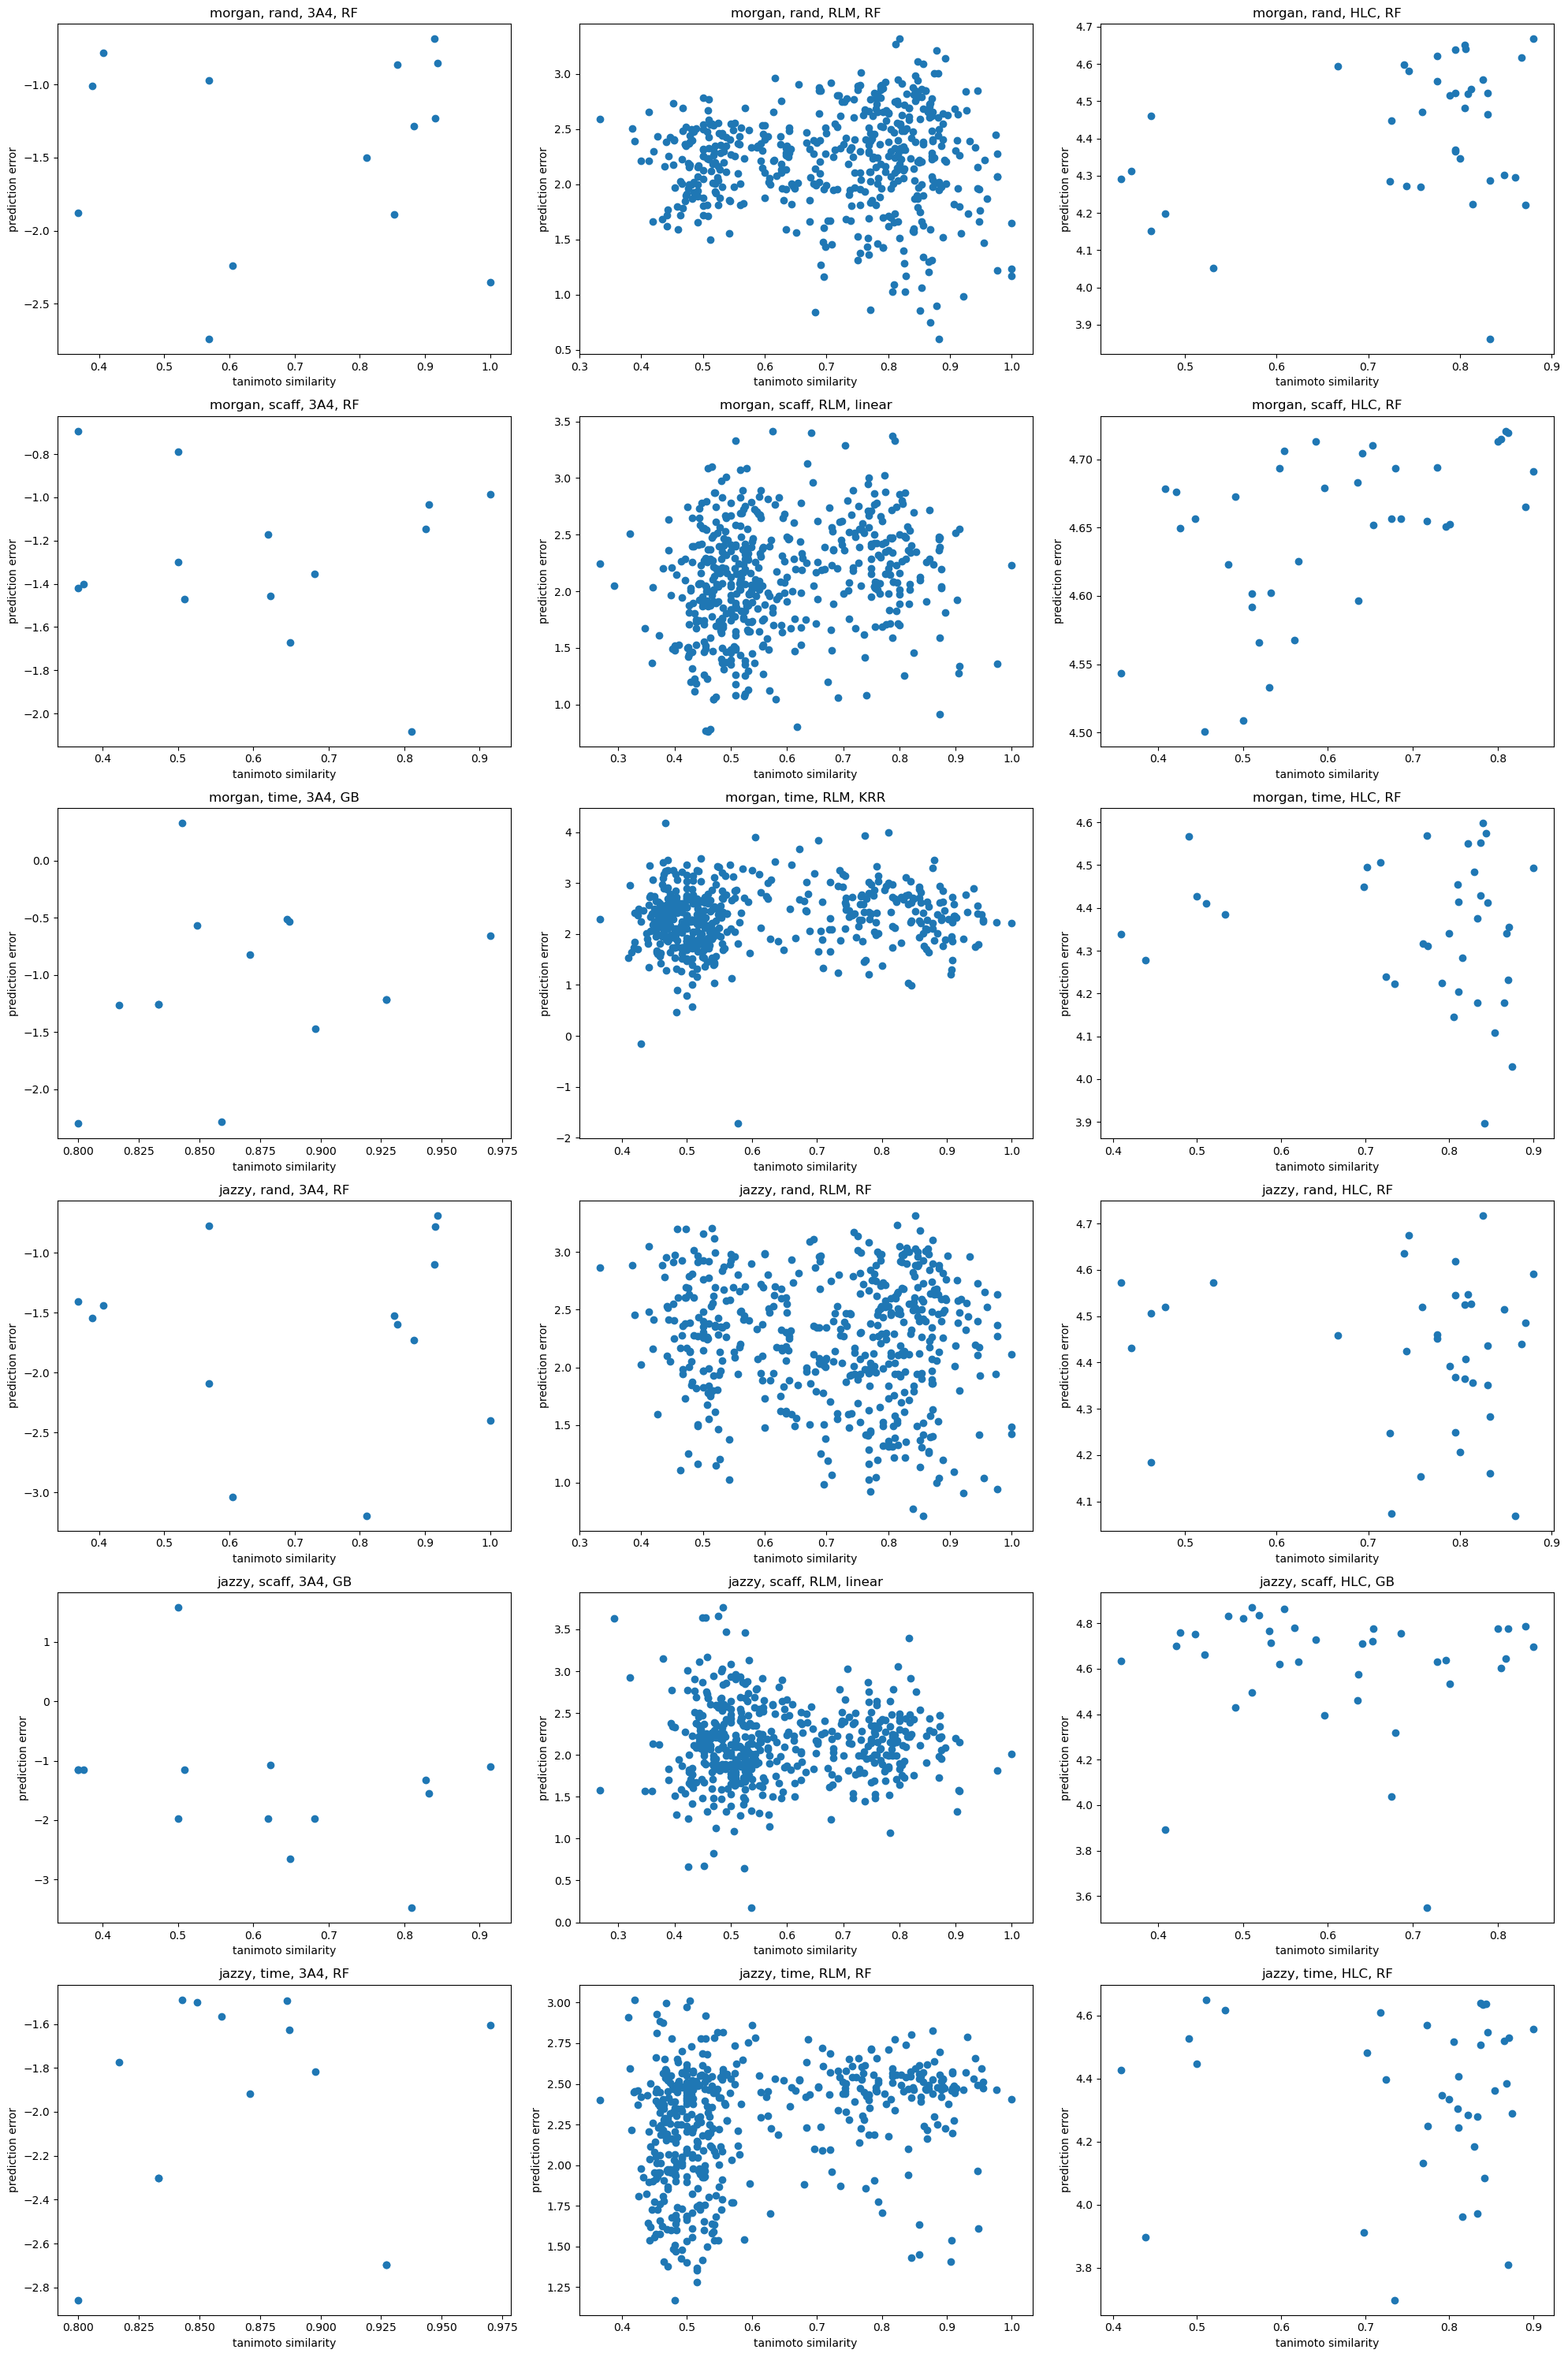

In [70]:
# Create a 20x3 grid of subplots
fig, axs = plt.subplots(6, 3, figsize=(20, 30))

plot_counter = 0
# Loop through each subplot and plot different data
for _type in feature_types:
    for splitter in splitters:
        for isozyme in isozymes:
            model_id = best_models[_type][splitter][isozyme]
            plot_x = tanimoto_sims[_type][splitter][isozyme]
            plot_y = y_predicted[_type][splitter][isozyme][model_id]

            # Get the current axis based on the plot counter
            ax = axs[plot_counter // 3, plot_counter % 3]

            # Plot the data and customize the subplot
            ax.scatter(plot_x, plot_y)
            ax.set_title(f'{_type}, {splitter}, {isozyme}, {model_id}')
            ax.set(xlabel='tanimoto similarity', ylabel='prediction error')

            plot_counter += 1

plt.tight_layout()  # Ensure the subplots are properly laid out
plt.show()

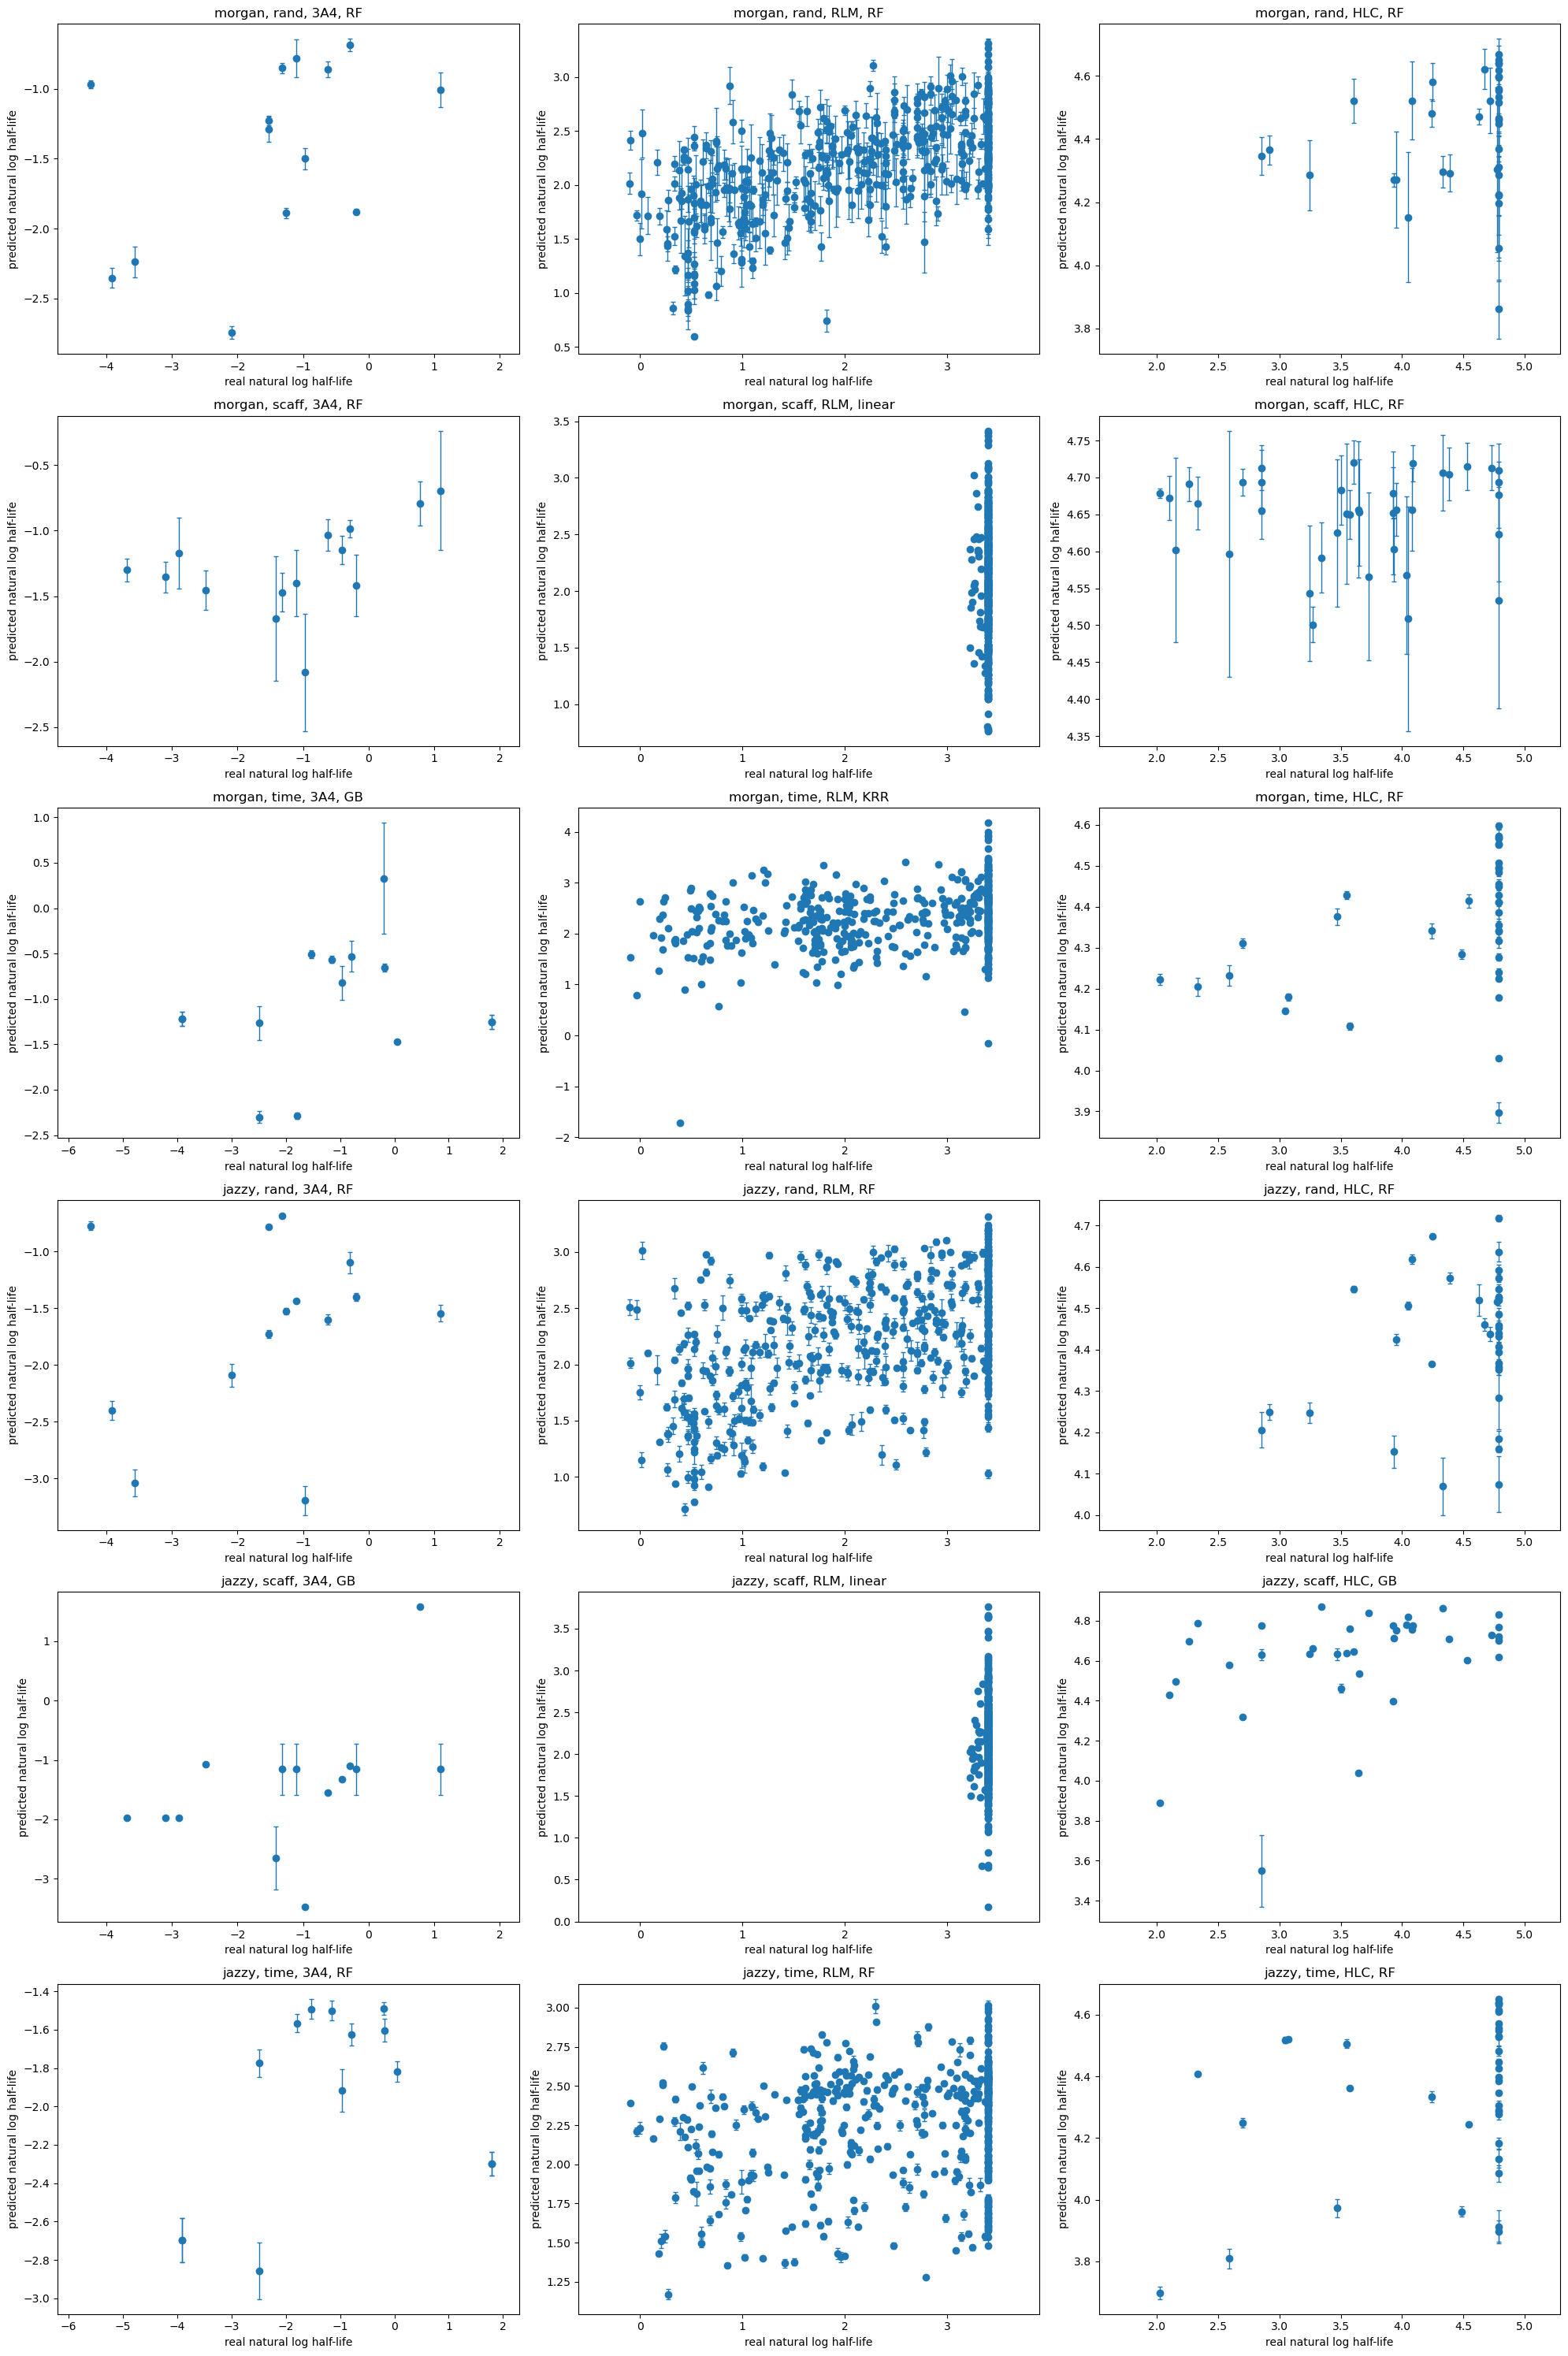

In [77]:
# Create a 20x3 grid of subplots
fig, axs = plt.subplots(6, 3, figsize=(20, 30))

plot_counter = 0
# Loop through each subplot and plot different data
for _type in feature_types:
    for splitter in splitters:
        for isozyme in isozymes:
            model_id = best_models[_type][splitter][isozyme]
            plot_x = np.log(halflives[_type][splitter][isozyme]["test"])
            plot_y = y_predicted[_type][splitter][isozyme][model_id]
            std = stds[_type][splitter][isozyme][model_id]

            all_dataset_halflives = np.log(list(halflives[_type][splitter][isozyme]["train"]) + list(halflives[_type][splitter][isozyme]["test"]))

            # Get the current axis based on the plot counter
            ax = axs[plot_counter // 3, plot_counter % 3]

            # Plot the data and customize the subplot
            ax.errorbar(plot_x, plot_y, yerr=std, fmt='o', linewidth=1, capsize=2)
            ax.set_title(f'{_type}, {splitter}, {isozyme}, {model_id}')
            ax.set_xlim([min(all_dataset_halflives) - 0.5, max(all_dataset_halflives) + 0.5])
            #ax.set_xlim([0, 3.3])
            ax.set(xlabel='real natural log half-life', ylabel='predicted natural log half-life')

            plot_counter += 1

plt.tight_layout()  # Ensure the subplots are properly laid out
plt.show()